In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import os
import matplotlib
from matplotlib.pyplot import imshow
from scipy.misc import imresize

In [2]:
class FashionMNIST(data.Dataset):
    def __init__(self, path, kind='train'):
        labels_path = os.path.join(path, kind + '-labels-idx1-ubyte')
        self.labels = np.frombuffer(open(labels_path, 'rb').read(), dtype=np.uint8, offset=8)
        images_path = os.path.join(path, kind + '-images-idx3-ubyte')
        self.images = np.frombuffer(open(images_path, 'rb').read(), dtype=np.uint8, offset=16).reshape(len(self.labels), 28, 28)
        assert len(self.images) == len(self.labels)
        self.class_names = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.images[index]
        img = imresize(img, [32, 32])
        img = np.reshape(img, [1, 32, 32])
        return img, self.labels[index]

path = 'data/fashion_mnist'
dataset = FashionMNIST(path)
test_dataset = FashionMNIST(path, 't10k')

(1, 32, 32)
(32, 32, 3)
pullover


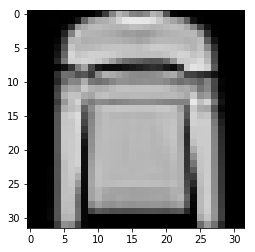

In [3]:
%matplotlib inline

def show(img):
    # input: CxWxH
    print(img.shape)
    whc = np.transpose(img, [1,2,0])
    rgb = np.tile(whc, [1,1,3])
    print(rgb.shape)
    imshow(rgb)

img1, label1 = dataset[5]
show(img1)
print(dataset.class_names[label1])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # starts off 28x28x1
        
        def layer(in_chans, out_chans):
            return [
                nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_chans),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ]
        
        # 32x32x1 -> 16x16x32 -> 8x8x64 -> 4x4x128 -> 2x2x128
        ops = layer(1, 32) + layer(32, 64) + layer(64, 128) + layer(128, 128)
        self.features = nn.Sequential(*ops)
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2*2*128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 2*2*128)
        x = self.classifier(x)
        return x

model = Net()

In [5]:
loader = data.DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(n_batches=1, print_n=20):
    model.train()
    for idx, (data, target) in enumerate(loader):
        if idx > n_batches: break
        data = Variable(data.type(torch.FloatTensor))
        target = Variable(target.type(torch.LongTensor))
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if idx % print_n == 0 or idx == n_batches-1:
            print(idx, "loss:", loss)

train(1000)

0 loss: Variable containing:
 2.4573
[torch.FloatTensor of size 1]

20 loss: Variable containing:
 1.4689
[torch.FloatTensor of size 1]

40 loss: Variable containing:
 1.1071
[torch.FloatTensor of size 1]

60 loss: Variable containing:
 0.8149
[torch.FloatTensor of size 1]

80 loss: Variable containing:
 0.5013
[torch.FloatTensor of size 1]

100 loss: Variable containing:
 1.0131
[torch.FloatTensor of size 1]

120 loss: Variable containing:
 0.4976
[torch.FloatTensor of size 1]

140 loss: Variable containing:
 0.6990
[torch.FloatTensor of size 1]

160 loss: Variable containing:
 0.5137
[torch.FloatTensor of size 1]

180 loss: Variable containing:
 0.4686
[torch.FloatTensor of size 1]

200 loss: Variable containing:
 0.5670
[torch.FloatTensor of size 1]

220 loss: Variable containing:
 0.6001
[torch.FloatTensor of size 1]

240 loss: Variable containing:
 0.5183
[torch.FloatTensor of size 1]

260 loss: Variable containing:
 1.3112
[torch.FloatTensor of size 1]

280 loss: Variable contain

KeyboardInterrupt: 

In [6]:
test_loader = data.DataLoader(dataset, shuffle=True, batch_size=16)

def accuracy():
    model.eval()
    correct = 0
    total = 0
    for idx, (data, target) in enumerate(test_loader):
        data = Variable(data.type(torch.FloatTensor))
        predictions = model(data).data.max(1)[1]
        correct += predictions.eq(target.type(torch.LongTensor)).sum()
        total += len(target)
        if idx > 100: break
    return correct / total

print("Accuracy:", accuracy())

Accuracy: 0.8480392156862745
